In [ ]:
!pip install -U spaCy
!python -m spacy download en_core_web_sm
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Text Categorization

The goal is to classify documents according to a set of predifined classes (labels).

We need training data for training a supervised approaches.

The process for training a classifier:
1. Load training data
2. Data pre-processing
3. Create and extract features
4. Training a model

For testing:
1. Load test data
2. Generate feature using the same approach adopted during the training
3. Classify test instances
4. Compute metrics

We use spaCy for text processing and scikit-learn for machine learning.

We define some functions for text processing.
We build also a class for implementing a custom Trasformer based on spaCy. This trasformer will process the text.

In [1]:
import pandas as pd
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import KFold

#init spaCy
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()  #component of SpaCy for the English Language

# Custom transformer using spaCy
class predictors(TransformerMixin):   #Create a custom trasformer that inherits from TransofrmerMixin
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]

    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

Download data from this link: https://drive.google.com/drive/folders/1pQKHrUth2x3lR-W74LKwtke-kQRIbR6U?usp=drive_link

Training data loading and feature creation. We exploit BoW+TfIdf as features.

In [6]:
df_train = pd.read_csv('train.csv', sep=",", header=None, names=["label","text"])
#BoW with word count
vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))  #class of ScikitLearn that transforms text in vector
#vector create a BoW model

#BoW with TF-IDF
#vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
X_train = df_train['text'] # the features
y_train = df_train['label'] # the labels
print(df_train.info)

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': <function spacy_tokenizer at 0x7b5af4b06fc0>, 'vocabulary': None}
<bound method DataFrame.info of          label                                               text
0         earn  champion products ch approves stock split cham...
1          acq  computer terminal systems cpml completes sale ...
2         earn  cobanco inc cbco year net shr cts vs dlrs net ...
3         earn  am international inc am nd qtr jan oper shr lo...
4         earn  brown forman inc bfd th qtr net shr one dlr vs...
...        ...                                                ...
5480      earn  kelly oil and gas partners kly year dec shr ct...
5481  money-fx  japan seeks t

Build the model.

In [7]:
# Linear Support Vector Machine classifier
classifier = svm.LinearSVC(max_iter=10000)
# Multi-layer Perceptron classifier
#classifier = neural_network.MLPClassifier()
# Create the pipeline
pipe = Pipeline([("cleaner", predictors()),
('vectorizer', vector),
('classifier', classifier)])
# Fit the model
pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7b5c09f6c110>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7b5af4b06fc0>)),
                ('classifier', LinearSVC(max_iter=10000))])

Load data and generate features.

In [9]:
df_test=pd.read_csv('test.csv', sep=",", header=None, names=["label","text"])
X_test = df_test['text'] # the features
y_test = df_test['label'] # the labels

Compute predictions on the test set and calculate metrics.

In [10]:
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
precision = metrics.precision_score(y_test, predicted, average='macro')
recall = metrics.recall_score(y_test, predicted, average='macro')
fm = metrics.f1_score(y_test, predicted, average='macro')
print("P={0}, R={1}, F1={2}".format(precision, recall, fm))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Accuracy: 0.9625399725902238
P=0.9078969005394343, R=0.8845163944095096, F1=0.8933137827279773
              precision    recall  f1-score   support

         acq     0.9684    0.9684    0.9684       696
       crude     0.9431    0.9587    0.9508       121
        earn     0.9826    0.9926    0.9876      1083
       grain     0.8182    0.9000    0.8571        10
    interest     0.8734    0.8519    0.8625        81
    money-fx     0.8333    0.8046    0.8187        87
        ship     0.9231    0.6667    0.7742        36
       trade     0.9211    0.9333    0.9272        75

    accuracy                         0.9625      2189
   macro avg     0.9079    0.8845    0.8933      2189
weighted avg     0.9621    0.9625    0.9619      2189



Build the confusion matrix.

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
print(cm)

[[ 674    1   15    0    0    3    0    3]
 [   2  116    0    1    0    0    2    0]
 [   7    1 1075    0    0    0    0    0]
 [   0    0    0    9    1    0    0    0]
 [   0    0    1    0   69    9    0    2]
 [   8    1    0    0    7   70    0    1]
 [   3    3    3    0    2    1   24    0]
 [   2    1    0    1    0    1    0   70]]


Visualize the confusion matrix.

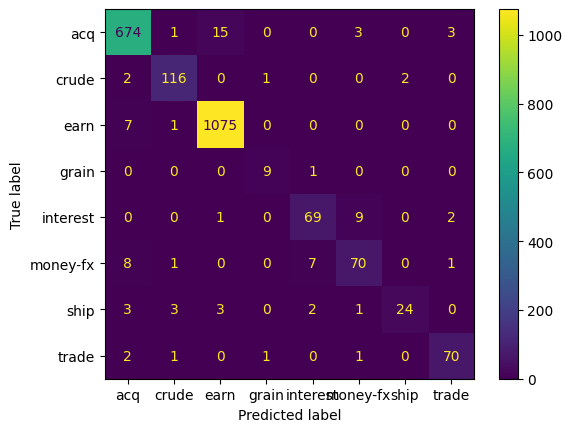

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

If the test set is unavailable, you can still evaluate your model using k-fold cross-validation.

In [13]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
fmicro = 0
fmacro = 0
for train_index, test_index in kf.split(X_train):
  pipe.fit(X_train[train_index], y_train[train_index])
  predicted = pipe.predict(X_train[test_index])
  fmacro = fmacro + metrics.f1_score(y_train[test_index], predicted, average='macro')
  fmicro = fmicro + metrics.f1_score(y_train[test_index], predicted, average='micro')
print("F-macro: ",fmacro/5)
print("F-micro: ",fmicro/5)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F-macro:  0.9133685541572041
F-micro:  0.9631722880583411


# HaSpeeDe – Political and Religious Hate Speech Detection

We use text categorization approaches for solving the hate speech detection task in Italian.
We have two labels (Si, No).

Data: https://drive.google.com/drive/folders/1pQKHrUth2x3lR-W74LKwtke-kQRIbR6U?usp=sharing

Define a new tokenizer for the Italian language.

In [17]:
!python -m spacy download it_core_news_sm


nlp_it = spacy.load("it_core_news_sm")
stop_words_it = spacy.lang.it.stop_words.STOP_WORDS
parser_it = Italian()

# Tokenizer function
def spacy_tokenizer_it(sentence):
    mytokens = parser_it(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words_it and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
! head -n 5 haspeede_training_textual_PROMPT.jsonl

{"instruction": "Stabilisci se il tweet in input contiene discorsi che incitano all'odio. Rispondi con si o no.", "input": "@unknown Con tutte le denunce che si sta beccando, Salvini rischia di far aumentare le statistiche dei reati commessi da italiani.", "output": "Si"}
{"instruction": "Stabilisci se il tweet in input contiene discorsi che incitano all'odio. Rispondi con si o no.", "input": "#PRESCRIZIONE : I (t)re magi hanno trovato l\u2019accordo: sar\u00e0 la prima legge con procedura d\u2019urgenza che per\u00f2 entra in vigore tra pi\u00f9 di un anno. \nNasce la categoria della \u201curgenza in differita\u201d. \n\nSe non ci fosse da piangere per l\u2019Italia, con il #m5s sarebbe tutto da ridere.", "output": "No"}
{"instruction": "Stabilisci se il tweet in input contiene discorsi che incitano all'odio. Rispondi con si o no.", "input": "Il #m5s ha votato contro le #unionicivili adducendo scuse vergognose, ma sostiene il #ddlPillon che riporta l\u2019Italia nel medioevo sul divor

In [20]:
import json

# Load training data
file = open('haspeede_training_textual_PROMPT.jsonl', 'r')
X_train = []
Y_train = []
for l in file:
  jo = json.loads(l)
  X_train.append(jo['input'])
  Y_train.append(jo['output'])
file.close()

# Use tf-idf as feature value
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
classifier = svm.LinearSVC(max_iter=1000)
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train, Y_train)

# Load test data
file = open('haspeede_test_textual_gold_PROMPT.jsonl', 'r')
X_test = []
Y_test = []
for l in file:
  jo = json.loads(l)
  X_test.append(jo['input'])
  Y_test.append(jo['output'])
file.close()

predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(Y_test, predicted)
print("Accuracy:", acc)
print(metrics.classification_report(Y_test, predicted, digits=4))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.8220454545454545
              precision    recall  f1-score   support

          No     0.8400    0.9343    0.8846      3213
          Si     0.7446    0.5181    0.6110      1187

    accuracy                         0.8220      4400
   macro avg     0.7923    0.7262    0.7478      4400
weighted avg     0.8142    0.8220    0.8108      4400



# Exercises


1.   Try to improve the classification performance on the haspeede task.
2.   Implement a classifier for the HODI task. Training and testing data are available here: https://drive.google.com/drive/folders/1pQKHrUth2x3lR-W74LKwtke-kQRIbR6U?usp=drive_link

